# Assignment 3

## Instructions
- Run this notebook on ```Google Colab(preferable)```
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells. 

## Packages Used
- sklearn [link](https://scikit-learn.org/)
- Keras [link](https://keras.io/guides/)

## Submission
- Rename the notebook to `<roll_number>_Assignment3_Q3.ipynb`.


## Question 3
Fake news is a widespread problem and there are many methods for combating it.
You have to build a fake news detection system using a ML model. Train any ML model (ANN, LSTM) over the given Dataset.
The dataset has short statements spoken by people and has the meta-information and corresponding label for those sentences. 
Your target is label column which has 6 labels(in the increasing order of truthfullness): pants-fire, false, barely-true, half-true, mostly-true, true.

The features are 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'venue' and the target is column "label".

The statement is made by speaker whose job, party are given along with 6 columns which are an account of the  type of news(labels) the person has shared before. 
The person who has shared fake content before is likely to share it in future and this can be accounted by the ML model as a feature. Column barely_true_c contains how many barely_true news has the speaker shared (and so is with column X_c, value of X_c is number of X the person shared).


You have to perform two tasks:
* task1: Binary classification <br>
Classify the given news as true/false. Take the labels pants-fire, false, barely-true as false and rest (half-true, mostly-true, true) as true.
* task2: Six-way classification <br>
Classify the given news into six-classes "pants-fire, false, barely-true, half-true, mostly-true, true".

For each of the tasks:
1) Experiment with depth of network and try to fine-tune hyperparameters reporting your observations. <br>
2) Report the accuracy, f1-score, confusion matrix on train, val and test sets. <br>
3) Experiment with bag-of-words, glove and bert embeddings(code given in the below notebook) and report results. <br> Comment on what is the affect of embedding on the results.

The pre-processing code is provided, you need to write the training and test.

Note: You are supposed to train on trainset, fine-tune on val and just eval on test set. If found that you trained on val/test sets, the penalty will be incurred.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install numpy
# !pip install tensorflow
# !pip install re
# !pip install nltk
# !pip install keras
# !pip install sklearn

In [3]:
# Importing libraries
import numpy as np
import pandas as pd
from tensorflow import keras  #feel free to use any other library
import numpy as np

import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import np_utils


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train = pd.read_csv('q3_data/notebook/train.csv')
val = pd.read_csv('q3_data/notebook/val.csv')
test = pd.read_csv('q3_data/notebook/test.csv')

In [5]:
# Dropping the 'id' column
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
val.drop('id', axis = 1, inplace = True)

In [6]:
train.head(5)

,label,statement,subject,speaker,job,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,venue
0,False,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,False,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15,9,20,19,2,an interview on CNN


In [7]:
# Checking the shape of data
print(train.shape)
print(val.shape)
print(test.shape)

(10269, 13)
(1284, 13)
(1283, 13)


## Clean and pre-process data
* Replace missing values
* Remove numbers and special characters
* Convert to upper-case

We experiment with two types of processing, one directly appending the other attributes like subject, job, state, party to sentence and then applying bag of words on it.

Other being encoding sentence with glove embeddings and passing just that.

In [8]:

def dataPreprocessing(data):
    '''Function for cleaning the dataset
    '''
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = statement.split()
        
        # you can experiment with any other stemmers
        ps = PorterStemmer()
        statement = [ps.stem(word) for word in statement if not word in set(stopwords.words('english'))] # Stemming the dataset and removing stopwords
        statement = ' '.join(statement)
        subject = data['subject'][x].replace(',', ' ')
        speaker = data['speaker'][x]
        job = data['job'][x].lower()
        # job = job.replace(' ', '-')
        state = data['state'][x].lower()
        party = data['party'][x].lower()
        corpus.append(statement + ' '  + subject + ' ' + job + ' ' + state + ' ' + party)
    return corpus

In [9]:
x_train = dataPreprocessing(train)
x_val = dataPreprocessing(val) 
x_test = dataPreprocessing(test) 

In [10]:
x_train

['say anni list polit group support third trimest abort demand abortion state representative texas republican',
 'declin coal start start natur ga took start begin presid georg w bush administr energy history job-accomplishments state delegate virginia democrat',
 'hillari clinton agre john mccain vote give georg bush benefit doubt iran foreign-policy president illinois democrat',
 'health care reform legisl like mandat free sex chang surgeri health-care no-job no-state none',
 'econom turnaround start end term economy jobs no-job florida democrat',
 'chicago bear start quarterback last year total number tenur uw faculti fire last two decad education wisconsin assembly speaker wisconsin republican',
 'jim dunnam live district repres year candidates-biography no-job texas republican',
 'person stage work activ last year pass along russ feingold toughest ethic reform sinc waterg ethics president illinois democrat',
 'howev took million oregon lotteri fund port newport eventu land new noa

In [11]:
len(x_train), len(x_val), len(x_test)

(10269, 1284, 1283)

In [12]:
corpus = x_train + x_val + x_test

In [13]:
len(corpus)

12836

## Using bag-of-words embedding


In [14]:
# Converting the corpus into bag-of-words
cv = CountVectorizer(max_features = 8000)
X = cv.fit_transform(corpus).toarray()

In [15]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
X.shape

(12836, 8000)

In [17]:
train.columns

Index(['label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
       'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c', 'venue'],
      dtype='object')

In [18]:
# Selecting the columns 'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c'
label_cols = ['barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c']
x_train2 = train[label_cols]
x_val2 = val[label_cols]
x_test2 = test[label_cols]

In [19]:
# Stacking x_train and x_train2 horizontally
x_train_bow = np.hstack((X[:len(x_train)], x_train2))
x_val_bow = np.hstack((X[len(x_train):len(x_train)+len(x_val)], x_val2))
x_test_bow = np.hstack((X[len(x_train)+len(x_val):], x_test2))

In [20]:
x_train_bow.shape

(10269, 8005)

In [21]:
x_train_bow

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   1,   1,   0],
       [  0,   0,   0, ..., 160, 163,   9],
       ...,
       [  0,   0,   0, ...,   5,   3,   3],
       [  0,   0,   0, ...,   3,   0,   0],
       [  0,   0,   0, ...,   1,   0,   2]])

## Use of Glove Embedding


download glove embeddings from 'https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip'
and place in your current working folder


In [22]:
#!unzip "glove.6B.zip" -d "glove"

In [23]:
emmbed_dict = {}
with open('drive/MyDrive/notebook/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],dtype="float32")
    # vector = values[1:]
    emmbed_dict[word]=vector


In [24]:
emmbed_dict['oov'] = np.zeros(200)

# emmbed_dict['oov'] = listofzeros = [0] * 200

In [25]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [26]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def dataPreprocessing_glove(data):
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = word_tokenize(statement)

        embed_statement = []
        for w in statement:
            if w in emmbed_dict:
                embed_statement.append(emmbed_dict[w])
            else:
                embed_statement.append(emmbed_dict['oov'])
         
        # bonus: Think how you can encode the below features(hint: look upon label encoding or training your own word2vec or any other embedding model)
    
#         subject = data['subject'][x].replace(',', ' ')
#         speaker = data['speaker'][x]
#         job = data['job'][x].lower()
#         # job = job.replace(' ', '-')
#         state = data['state'][x].lower()
#         party = data['party'][x].lower()
        corpus.append(embed_statement)
    
    return np.array(corpus)
    # return corpus


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
x_train_glove = dataPreprocessing_glove(train)
x_val_glove = dataPreprocessing_glove(val)
x_test_glove = dataPreprocessing_glove(test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [28]:
new_x_train_glove=[]
new_x_val_glove=[]
new_x_test_glove=[]

In [29]:
for each in x_train_glove:
  length = len(each)
  if(length<69):
    # temp = [np.zeros(69-length)]
    temp = [np.zeros(200)]
    temp = temp*(69-length)
    each = each + temp
  else:
    each = each[:69]
  new_x_train_glove.append(np.array(each).flatten())

for each in x_val_glove:
  length = len(each)
  if(length<69):
    # temp = [np.zeros(69-length)]
    temp = [np.zeros(200)]
    temp = temp*(69-length)
    each = each + temp
  else:
    each = each[:69]
  new_x_val_glove.append(np.array(each).flatten())

for each in x_test_glove:
  length = len(each)
  if(length<69):
    temp = [np.zeros(200)]
    temp = temp*(69-length)
    each = each + temp
  else:
    each = each[:69]
  new_x_test_glove.append(np.array(each).flatten())

x_train_glove = np.array(new_x_train_glove)
x_val_glove = np.array(new_x_val_glove)
x_test_glove = np.array(new_x_test_glove)


In [30]:

print(x_train_glove.shape)
print(x_val_glove.shape)
print(x_test_glove.shape)

# print(type(x_train_glove))

(10269, 13800)
(10269, 13800)
(10269, 13800)


In [31]:
# for each in new_x_train_glove:
#   print(len(each))
# print(len(x_train_glove[0]))
x_train_glove.shape

(10269, 13800)

In [32]:
x_train_glove = np.hstack((X[:len(x_train)], x_train2))
x_val_glove = np.hstack((X[len(x_train):len(x_train)+len(x_val)], x_val2))
x_test_glove = np.hstack((X[len(x_train)+len(x_val):], x_test2))


In [33]:
# print(x_train_glove.shape)
# print(x_val_glove.shape)
# print(x_test_glove.shape)


In [34]:
# x_train_glove = np.hstack((x_train_glove.reshape(-1,1), x_train2))
# x_val_glove = np.hstack((x_val_glove.reshape(-1,1), x_val2))
# x_test_glove = np.hstack((x_test_glove.reshape(-1,1), x_test2))

In [35]:
x_train_glove.shape
# print(type(x_train_glove))

(10269, 8005)

## Use of bert embeddings
note: we used our pre-processed code for bow which has the attributed appended to end the end of sentence. 

In [36]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

x_train_bert = np.hstack((model.encode(x_train), x_train2))
x_val_bert = np.hstack((model.encode(x_val), x_val2))
x_test_bert = np.hstack((model.encode(x_test), x_test2))

In [37]:
print(x_train_bow.shape)
print(x_train_bert.shape)
print(x_train_glove.shape)


(10269, 8005)
(10269, 389)
(10269, 8005)


Now use the above 3 types of embedded inputs(bow, glove, bert embeddings) for the 2 classification tasks and compare their outputs


# Six-way classification

## Preprocessing

In [38]:
num_classes = 6
# Preprocessing function for the labels
def categorize(data):
    y = data["label"].tolist()

    # Encoding the Dependent Variable
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)

    # Converting to binary class matrix
    y = np_utils.to_categorical(y, num_classes)
    return y

In [39]:
y_train_six_way = categorize(train)
y_test_six_way = categorize(test)
y_val_six_way = categorize(val)

In [40]:
y_train_six_way

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


## Model

In [41]:
## write your code here
# Initialize hyperparameters
# Create model
# train
# test
# report accuracy, f1-score and confusion matrix


import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import asarray, zeros


In [42]:
def define_model(input_dim1):
  model = Sequential()
  model.add(Dense(1000, input_dim=input_dim1, activation='relu'))
  model.add(Dense(6, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def predict(model,x_train_bow1,x_val_bow1,x_test_bow1):
  prediction_test_bow = model.predict(x_test_bow1)
  prediction_val_bow = model.predict(x_val_bow1)
  prediction_train_bow = model.predict(x_train_bow1)
  prediction_test_bow = tf.one_hot(tf.argmax(prediction_test_bow ,axis=1), depth = 6)
  prediction_val_bow = tf.one_hot(tf.argmax(prediction_val_bow ,axis=1), depth = 6)
  prediction_train_bow = tf.one_hot(tf.argmax(prediction_train_bow ,axis=1), depth = 6)
  prediction_test_bow = np.array(prediction_test_bow)
  prediction_val_bow = np.array(prediction_val_bow)
  prediction_train_bow = np.array(prediction_train_bow)
  return prediction_train_bow,prediction_val_bow,prediction_test_bow

def predict_binary(model,x_train_bow1,x_val_bow1,x_test_bow1):
  prediction_test_bow = model.predict(x_test_bow1)
  prediction_val_bow = model.predict(x_val_bow1)
  prediction_train_bow = model.predict(x_train_bow1)
  prediction_test_bow = tf.one_hot(tf.argmax(prediction_test_bow ,axis=1), depth = 2)
  prediction_val_bow = tf.one_hot(tf.argmax(prediction_val_bow ,axis=1), depth = 2)
  prediction_train_bow = tf.one_hot(tf.argmax(prediction_train_bow ,axis=1), depth = 2)
  prediction_test_bow = np.array(prediction_test_bow)
  prediction_val_bow = np.array(prediction_val_bow)
  prediction_train_bow = np.array(prediction_train_bow)
  return prediction_train_bow,prediction_val_bow,prediction_test_bow

def print_confusion_matrix(y_train_six_way1,y_val_six_way1,y_test_six_way1,prediction_train_bow1,prediction_val_bow1,prediction_test_bow1):
  conf_matrix_test_bow = confusion_matrix(y_true=y_test_six_way1.argmax(axis=1), y_pred=prediction_test_bow1.argmax(axis=1))
  conf_matrix_val_bow = confusion_matrix(y_true=y_val_six_way1.argmax(axis=1), y_pred=prediction_val_bow1.argmax(axis=1))
  conf_matrix_train_bow = confusion_matrix(y_true=y_train_six_way1.argmax(axis=1), y_pred=prediction_train_bow1.argmax(axis=1))

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix_test_bow, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix_test_bow.shape[0]):
      for j in range(conf_matrix_test_bow.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix_test_bow[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix_test', fontsize=18)
  plt.show()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix_val_bow, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix_val_bow.shape[0]):
      for j in range(conf_matrix_val_bow.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix_val_bow[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix_val', fontsize=18)
  plt.show()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix_train_bow, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix_train_bow.shape[0]):
      for j in range(conf_matrix_train_bow.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix_train_bow[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix_train', fontsize=18)
  plt.show()

def print_f1_score(y_train,y_val,y_test,prediction_train,prediction_val,prediction_test):
  print('F1 Score Train : %.3f' % f1_score(y_train, prediction_train,average='micro'))
  print('F1 Score Val : %.3f' % f1_score(y_val, prediction_val,average='micro'))
  print('F1 Score Test : %.3f' % f1_score(y_test, prediction_test,average='micro'))

def get_accuracy(model,x_train,x_val,x_test,y_train,y_val,y_test):
  train_results = model.evaluate(x_train, y_train, batch_size=128)
  val_results = model.evaluate(x_val, y_val, batch_size=128)
  test_results = model.evaluate(x_test, y_test, batch_size=128)
  print("Training Accuracy : %.3f" %(train_results[1]*100),"%")
  print("Validation Accuracy : %.3f" %(val_results[1]*100),"%")
  print("Test Accuracy : %.3f" %(test_results[1]*100),"%")






Epoch 1/10
1027/1027 [==============================] - 11s 8ms/step - loss: 1.6334 - accuracy: 0.3600 - val_loss: 1.4061 - val_accuracy: 0.4377
Epoch 2/10
1027/1027 [==============================] - 8s 8ms/step - loss: 1.0966 - accuracy: 0.5674 - val_loss: 1.5024 - val_accuracy: 0.3988
Epoch 3/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.8051 - accuracy: 0.7047 - val_loss: 1.7628 - val_accuracy: 0.3808
Epoch 4/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.6157 - accuracy: 0.7933 - val_loss: 2.0921 - val_accuracy: 0.3645
Epoch 5/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.4628 - accuracy: 0.8471 - val_loss: 2.3581 - val_accuracy: 0.3676
Epoch 6/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.3820 - accuracy: 0.8817 - val_loss: 2.7296 - val_accuracy: 0.3629
Epoch 7/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.2812 - accuracy: 0.9134 - val_loss: 2.8742 - val_accuracy

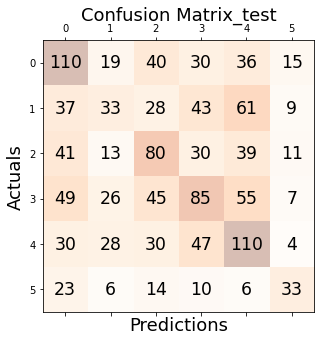

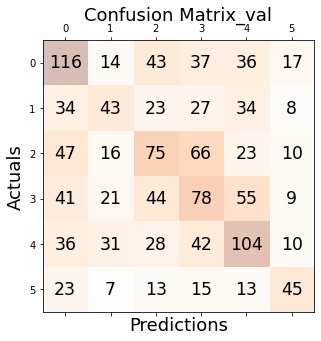

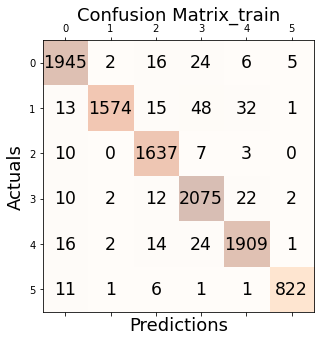

F1 Score Train : 0.970
F1 Score Val : 0.359
F1 Score Test : 0.352
11/11 [==============================] - 0s 8ms/step - loss: 3.5668 - accuracy: 0.3515
Training Accuracy : 97.010 %
Validation Accuracy : 35.903 %
Test Accuracy : 35.152 %


In [43]:
bow_model = define_model(x_train_bow.shape[1])
hist = bow_model.fit(x_train_bow, y_train_six_way, epochs=10, batch_size=10, validation_data=(x_val_bow, y_val_six_way))
prediction_train_bow,prediction_val_bow,prediction_test_bow = predict(bow_model,x_train_bow,x_val_bow,x_test_bow)
print_confusion_matrix(y_train_six_way,y_val_six_way,y_test_six_way,prediction_train_bow,prediction_val_bow,prediction_test_bow)
print_f1_score(y_train_six_way,y_val_six_way,y_test_six_way,prediction_train_bow,prediction_val_bow,prediction_test_bow)
get_accuracy(bow_model,x_train_bow,x_val_bow,x_test_bow,y_train_six_way,y_val_six_way,y_test_six_way)




Epoch 1/10
1027/1027 [==============================] - 5s 4ms/step - loss: 1.8384 - accuracy: 0.3477 - val_loss: 1.4723 - val_accuracy: 0.4089
Epoch 2/10
1027/1027 [==============================] - 4s 4ms/step - loss: 1.3482 - accuracy: 0.4659 - val_loss: 1.4001 - val_accuracy: 0.4112
Epoch 3/10
1027/1027 [==============================] - 6s 6ms/step - loss: 1.2133 - accuracy: 0.5107 - val_loss: 1.3654 - val_accuracy: 0.4361
Epoch 4/10
1027/1027 [==============================] - 4s 4ms/step - loss: 1.1075 - accuracy: 0.5543 - val_loss: 1.3588 - val_accuracy: 0.4299
Epoch 5/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.9985 - accuracy: 0.6102 - val_loss: 1.4425 - val_accuracy: 0.4338
Epoch 6/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.8782 - accuracy: 0.6639 - val_loss: 1.5628 - val_accuracy: 0.4097
Epoch 7/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.7731 - accuracy: 0.7145 - val_loss: 1.6921 - val_accuracy:

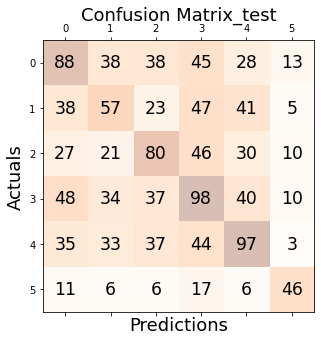

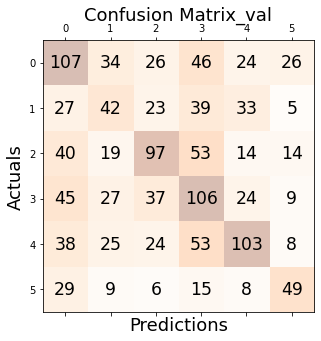

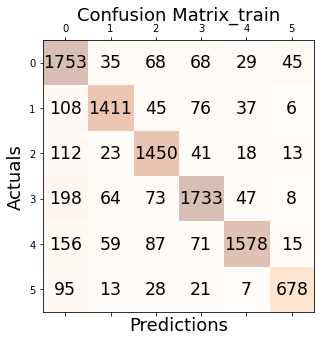

F1 Score Train : 0.838
F1 Score Val : 0.393
F1 Score Test : 0.363
11/11 [==============================] - 0s 4ms/step - loss: 2.2513 - accuracy: 0.3632
Training Accuracy : 83.776 %
Validation Accuracy : 39.252 %
Test Accuracy : 36.321 %


In [44]:
bert_model = define_model(x_train_bert.shape[1])
hist = bert_model.fit(x_train_bert, y_train_six_way, epochs=10, batch_size=10, validation_data=(x_val_bert, y_val_six_way))
prediction_train_bert,prediction_val_bert,prediction_test_bert = predict(bert_model,x_train_bert,x_val_bert,x_test_bert)
print_confusion_matrix(y_train_six_way,y_val_six_way,y_test_six_way,prediction_train_bert,prediction_val_bert,prediction_test_bert)
print_f1_score(y_train_six_way,y_val_six_way,y_test_six_way,prediction_train_bert,prediction_val_bert,prediction_test_bert)
get_accuracy(bert_model,x_train_bert,x_val_bert,x_test_bert,y_train_six_way,y_val_six_way,y_test_six_way)



Epoch 1/10
1027/1027 [==============================] - 9s 8ms/step - loss: 1.6386 - accuracy: 0.3622 - val_loss: 1.4576 - val_accuracy: 0.4330
Epoch 2/10
1027/1027 [==============================] - 8s 8ms/step - loss: 1.0937 - accuracy: 0.5788 - val_loss: 1.5395 - val_accuracy: 0.3707
Epoch 3/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.7979 - accuracy: 0.7155 - val_loss: 1.7569 - val_accuracy: 0.3910
Epoch 4/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.5930 - accuracy: 0.8041 - val_loss: 2.0870 - val_accuracy: 0.3754
Epoch 5/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.4343 - accuracy: 0.8597 - val_loss: 2.3077 - val_accuracy: 0.3692
Epoch 6/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.3571 - accuracy: 0.8892 - val_loss: 2.6045 - val_accuracy: 0.3692
Epoch 7/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.2932 - accuracy: 0.9112 - val_loss: 2.8576 - val_accuracy:

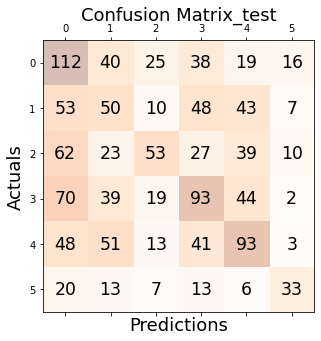

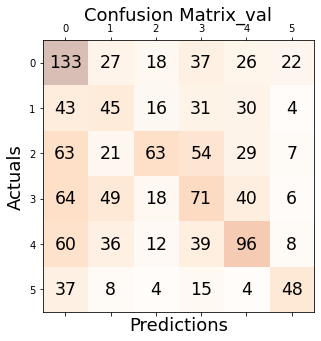

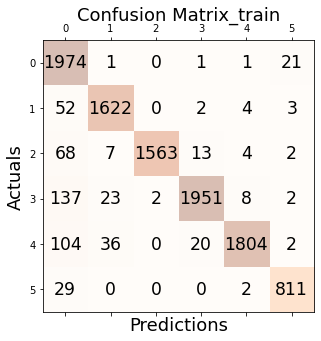

F1 Score Train : 0.947
F1 Score Val : 0.355
F1 Score Test : 0.338
11/11 [==============================] - 0s 8ms/step - loss: 3.6466 - accuracy: 0.3383
Training Accuracy : 94.703 %
Validation Accuracy : 35.514 %
Test Accuracy : 33.827 %


In [45]:
glove_model = define_model(x_train_glove.shape[1])
hist = glove_model.fit(x_train_glove, y_train_six_way, epochs=10, batch_size=10, validation_data=(x_val_glove, y_val_six_way))
prediction_train_glove,prediction_val_glove,prediction_test_glove = predict(glove_model,x_train_glove,x_val_glove,x_test_glove)
print_confusion_matrix(y_train_six_way,y_val_six_way,y_test_six_way,prediction_train_glove,prediction_val_glove,prediction_test_glove)
print_f1_score(y_train_six_way,y_val_six_way,y_test_six_way,prediction_train_glove,prediction_val_glove,prediction_test_glove)
get_accuracy(glove_model,x_train_glove,x_val_glove,x_test_glove,y_train_six_way,y_val_six_way,y_test_six_way)



# Binary Classification

## Preprocessing

In [46]:
num_classes = 2

In [47]:
# Function for preprocessing labels
def dataPreprocessingBinary(data):
    y = data["label"].tolist()

    # Changing the 'half-true', 'mostly-true', barely-true', 'pants-fire' labels to True/False for Binary Classification
    for x in range(len(y)):
        if(y[x] == 'half-true'):
            y[x] = 'True'
        elif(y[x] == 'mostly-true'):
            y[x] = 'True'
        elif(y[x] == 'barely-true'):
            y[x] = 'False'
        elif(y[x] == 'pants-fire'):
            y[x] = 'False'

    # Converting the lables into binary class matrix
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)
    y = np_utils.to_categorical(y, num_classes)
    return y

In [48]:
y_train_binary = dataPreprocessingBinary(train)
y_test_binary = dataPreprocessingBinary(test)
y_val_binary = dataPreprocessingBinary(val)

## Model
Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


In [49]:
## write your code here
# Initialize hyperparameters
# Create model
# train
# test
# report accuracy, f1-score and confusion matrix




In [50]:
def define_model_binary(input_dim1):
  model = Sequential()
  model.add(Dense(1000, input_dim=input_dim1, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model






In [51]:
print(y_train_binary.shape)
print(prediction_train_bow.shape)
print(y_val_binary.shape)
print(prediction_val_bow.shape)
print(y_test_binary.shape)
print(prediction_test_bow.shape)

(10269, 2)
(10269, 6)
(1284, 2)
(1284, 6)
(1283, 2)
(1283, 6)


In [52]:
# print('F1 Score Train : %.3f' % f1_score(y_train_binary, prediction_train_bow,average='micro'))
# prediction_train_bow
# y_train_binary

Epoch 1/10
1027/1027 [==============================] - 9s 8ms/step - loss: 0.6485 - accuracy: 0.6752 - val_loss: 0.5515 - val_accuracy: 0.6963
Epoch 2/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.4518 - accuracy: 0.7826 - val_loss: 0.5760 - val_accuracy: 0.7142
Epoch 3/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.3533 - accuracy: 0.8423 - val_loss: 0.7170 - val_accuracy: 0.6861
Epoch 4/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.2685 - accuracy: 0.8895 - val_loss: 0.8967 - val_accuracy: 0.6690
Epoch 5/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.2194 - accuracy: 0.9182 - val_loss: 0.9519 - val_accuracy: 0.6916
Epoch 6/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.1678 - accuracy: 0.9381 - val_loss: 1.0973 - val_accuracy: 0.6760
Epoch 7/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.1698 - accuracy: 0.9436 - val_loss: 1.1876 - val_accuracy:

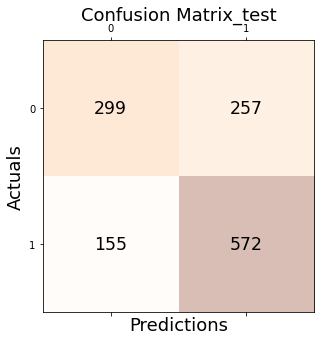

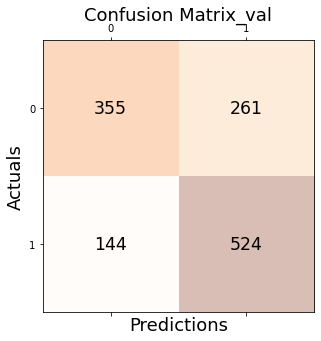

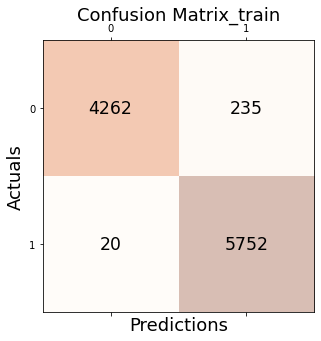

F1 Score Train : 0.975
F1 Score Val : 0.685
F1 Score Test : 0.679
11/11 [==============================] - 0s 9ms/step - loss: 1.6951 - accuracy: 0.6789
Training Accuracy : 97.517 %
Validation Accuracy : 68.458 %
Test Accuracy : 67.888 %


In [53]:
bow_model_binary = define_model_binary(x_train_bow.shape[1])
hist = bow_model_binary.fit(x_train_bow, y_train_binary, epochs=10, batch_size=10, validation_data=(x_val_bow, y_val_binary))
prediction_train_bow,prediction_val_bow,prediction_test_bow = predict_binary(bow_model_binary,x_train_bow,x_val_bow,x_test_bow)
print_confusion_matrix(y_train_binary,y_val_binary,y_test_binary,prediction_train_bow,prediction_val_bow,prediction_test_bow)
print_f1_score(y_train_binary,y_val_binary,y_test_binary,prediction_train_bow,prediction_val_bow,prediction_test_bow)
get_accuracy(bow_model_binary,x_train_bow,x_val_bow,x_test_bow,y_train_binary,y_val_binary,y_test_binary)




Epoch 1/10
1027/1027 [==============================] - 6s 6ms/step - loss: 0.7571 - accuracy: 0.6576 - val_loss: 0.5994 - val_accuracy: 0.6963
Epoch 2/10
1027/1027 [==============================] - 7s 6ms/step - loss: 0.5541 - accuracy: 0.7261 - val_loss: 0.5432 - val_accuracy: 0.7079
Epoch 3/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.4973 - accuracy: 0.7499 - val_loss: 0.5217 - val_accuracy: 0.7196
Epoch 4/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.4547 - accuracy: 0.7739 - val_loss: 0.5388 - val_accuracy: 0.7188
Epoch 5/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.4070 - accuracy: 0.8000 - val_loss: 0.5973 - val_accuracy: 0.7064
Epoch 6/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.3658 - accuracy: 0.8285 - val_loss: 0.6043 - val_accuracy: 0.6939
Epoch 7/10
1027/1027 [==============================] - 4s 4ms/step - loss: 0.3183 - accuracy: 0.8547 - val_loss: 0.7057 - val_accuracy:

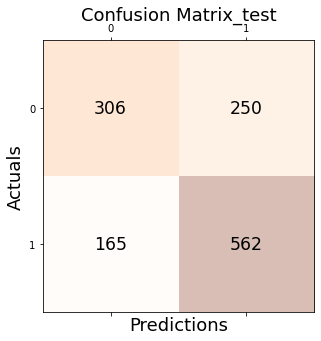

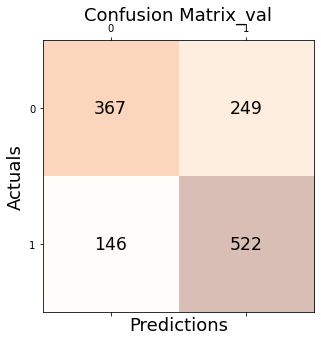

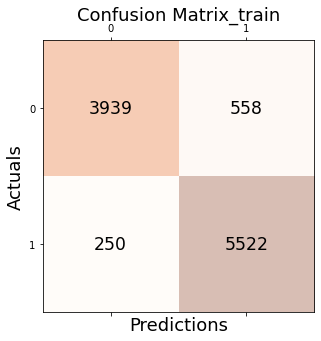

F1 Score Train : 0.921
F1 Score Val : 0.692
F1 Score Test : 0.677
11/11 [==============================] - 0s 3ms/step - loss: 0.9647 - accuracy: 0.6765
Training Accuracy : 92.132 %
Validation Accuracy : 69.237 %
Test Accuracy : 67.654 %


In [55]:
bert_model_binary = define_model_binary(x_train_bert.shape[1])
hist = bert_model_binary.fit(x_train_bert, y_train_binary, epochs=10, batch_size=10, validation_data=(x_val_bert, y_val_binary))
prediction_train_bert,prediction_val_bert,prediction_test_bert = predict_binary(bert_model_binary,x_train_bert,x_val_bert,x_test_bert)
print_confusion_matrix(y_train_binary,y_val_binary,y_test_binary,prediction_train_bert,prediction_val_bert,prediction_test_bert)
print_f1_score(y_train_binary,y_val_binary,y_test_binary,prediction_train_bert,prediction_val_bert,prediction_test_bert)
get_accuracy(bert_model_binary,x_train_bert,x_val_bert,x_test_bert,y_train_binary,y_val_binary,y_test_binary)



Epoch 1/10
1027/1027 [==============================] - 9s 9ms/step - loss: 0.6545 - accuracy: 0.6761 - val_loss: 0.5652 - val_accuracy: 0.6978
Epoch 2/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.4585 - accuracy: 0.7788 - val_loss: 0.5920 - val_accuracy: 0.6815
Epoch 3/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.3555 - accuracy: 0.8381 - val_loss: 0.6780 - val_accuracy: 0.6877
Epoch 4/10
1027/1027 [==============================] - 9s 9ms/step - loss: 0.2568 - accuracy: 0.8892 - val_loss: 0.8243 - val_accuracy: 0.6783
Epoch 5/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.2179 - accuracy: 0.9155 - val_loss: 0.9725 - val_accuracy: 0.6947
Epoch 6/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.2015 - accuracy: 0.9307 - val_loss: 1.1101 - val_accuracy: 0.6815
Epoch 7/10
1027/1027 [==============================] - 8s 8ms/step - loss: 0.1416 - accuracy: 0.9512 - val_loss: 1.2467 - val_accuracy:

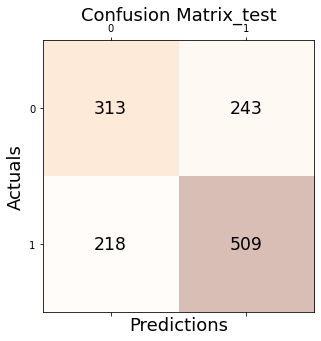

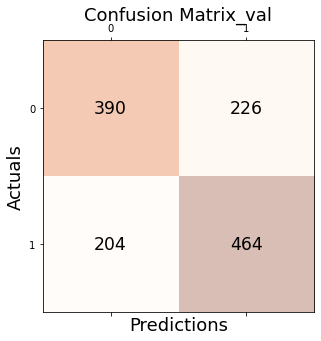

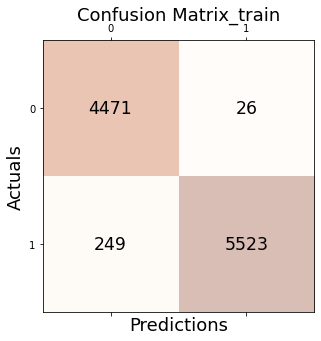

F1 Score Train : 0.973
F1 Score Val : 0.665
F1 Score Test : 0.641
11/11 [==============================] - 0s 8ms/step - loss: 1.6851 - accuracy: 0.6407
Training Accuracy : 97.322 %
Validation Accuracy : 66.511 %
Test Accuracy : 64.069 %


In [56]:
glove_model_binary = define_model_binary(x_train_glove.shape[1])
hist = glove_model_binary.fit(x_train_glove, y_train_binary, epochs=10, batch_size=10, validation_data=(x_val_glove, y_val_binary))
prediction_train_glove,prediction_val_glove,prediction_test_glove = predict_binary(glove_model_binary,x_train_glove,x_val_glove,x_test_glove)
print_confusion_matrix(y_train_binary,y_val_binary,y_test_binary,prediction_train_glove,prediction_val_glove,prediction_test_glove)
print_f1_score(y_train_binary,y_val_binary,y_test_binary,prediction_train_glove,prediction_val_glove,prediction_test_glove)
get_accuracy(glove_model_binary,x_train_glove,x_val_glove,x_test_glove,y_train_binary,y_val_binary,y_test_binary)

